In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.special import erf
from scipy.optimize import curve_fit
import datetime

In [2]:
ts = pd.read_csv("../data/ts_raw.csv")

In [3]:
base=np.datetime64('2019-12-31')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)


In [4]:
print('max day = %d, max date = %s' % (ts.day.max(), ts.Date.max()))

max day = 89, max date = 2020-03-29 00:00:00


In [5]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Country/Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])
tsAll = ts.groupby(['Date', 'day']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [6]:
def sigmoid(x, x0, yM, xf):
    y = expit((x-x0)*xf)*yM   # logistic
    #y1 = np.arctan((x-x0)*xf)/np.pi*yM + yM/2 # arctan
    #y2 = np.tanh((x-x0)*xf2)*yM/2 + yM/2 # tanh
    #y3 = erf((x-x0)*xf3)*yM/2 + yM/2 # erf
    return y

def startP0(x,y):
    return [(x.max()+x.min())/2, y.max(), 1]


In [7]:
def regionData(region, metric='Confirmed'):
    if region!=None:
        cdata = ts[(ts['Country/Region']==region)]
    else:
        cdata = tsAll
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [8]:
def estimate(region):
    x,y=regionData(region)

    try:
        p0 = startP0(x,y)
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [9]:
estimate('Italy')

(array([8.29028228e+01, 1.27168352e+05, 1.87663557e-01]),
 array([1.80640780e-01, 1.86018442e+03, 2.41978792e-03]))

In [10]:
def fitPlot(region, name=None, metric='Confirmed'):
    try:
        x,y=regionData(region, metric)

        if name==None:
            name=str(region)

        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Sigmoid fit for '+metric+' in '+name)

        try:
            p0 = startP0(x,y)
            popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
            perr = np.sqrt(np.diag(pcov))

            x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
            y_reg = sigmoid(x_reg, *popt)
            y_low = sigmoid(x_reg, popt[0]+perr[0], popt[1]-perr[1]*2, *(popt[2:]+perr[2:]))
            y_high= sigmoid(x_reg, popt[0]-perr[0], popt[1]+perr[1]*2, *(popt[2:]-perr[2:]))

            plt.plot(x_reg, y_reg, linewidth=3.0, label='fit')
            plt.fill_between(x_reg, y_low, y_high, alpha=0.5, label='95% conf')
        except:
            print('No fit for '+name)
            
        plt.plot(x, y, 'o', label='cases')

        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+name)

In [11]:
def estPlot(region, name=None, metric='Confirmed'):
    if name==None:
        name=str(region)

    yMFit = pd.DataFrame()

    x,y=regionData(region, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = startP0(sx,sy)
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[1]
            yM = popt[1]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+name)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error*2
    yHigh=yMFit.est+yMFit.error*2
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5, label='95% conf')
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, min(yMFit.cases.max()*3, max(yMFit.cases.max(),yMFit.est.max()*1.4)))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='upper left')
    
    plt.show()


In [12]:
def allPlots(region, name=None):
    fitPlot(region,name)
    fitPlot(region,name,'Deaths')
    estPlot(region,name)
    estPlot(region,name,'Deaths')


In [13]:
cRef,cRefErr = estimate('Italy')

In [14]:
def plotRegions(regions, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare countries with offset')

        for c in regions:
            try:
                pcov, perr = estimate(c)
                delay=int(pcov[0]-cRef[0])
                yM=pcov[1]
                x,y=regionData(c, metric)
                plt.plot(x-int(pcov[0]), y/yM, linewidth=2.0, label= "%s (%d days, max %.1fk)" % (c, delay, yM/1000)) 
            except:
                print('No fit for '+metric+' in '+c)

        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.show()
    except:
        print('No fit for '+metric+' in '+c)

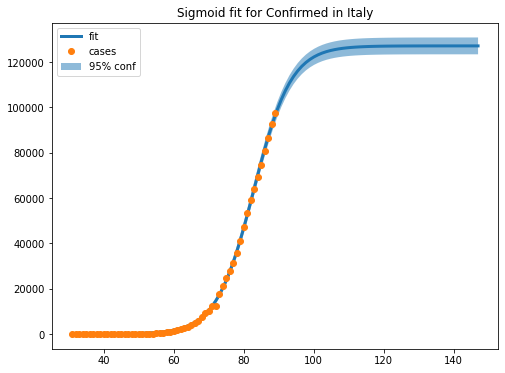

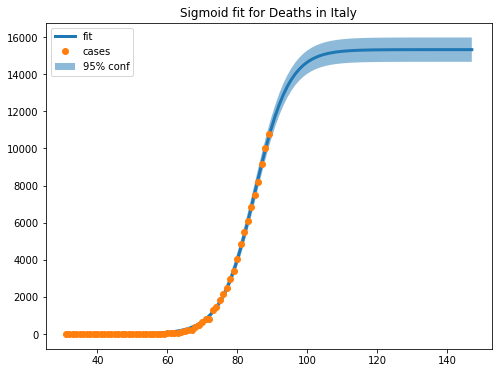

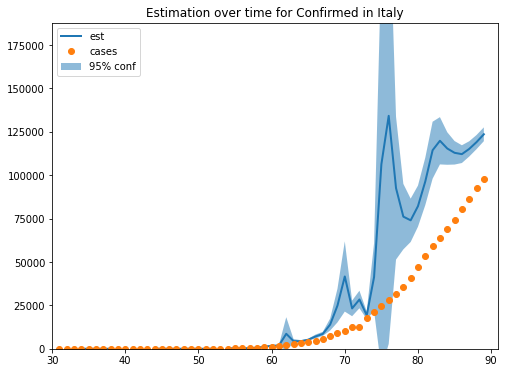

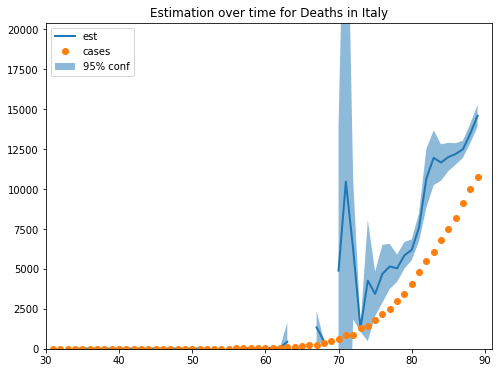

In [15]:
allPlots('Italy')

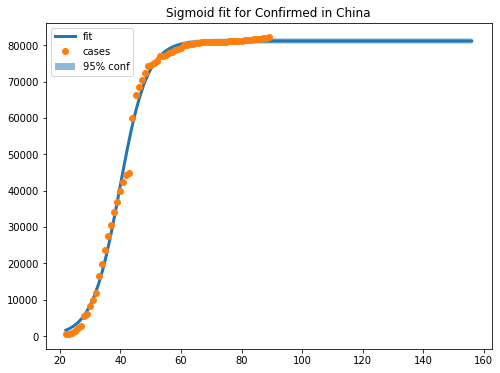

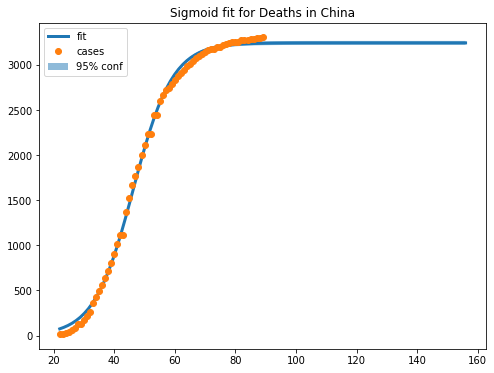

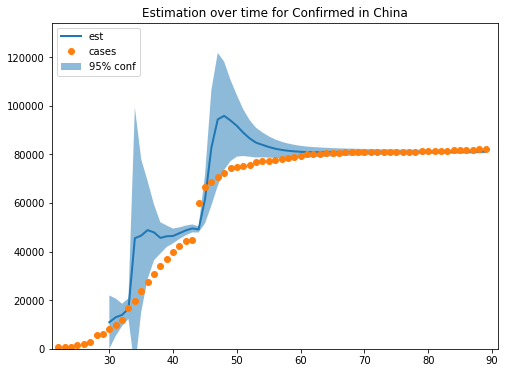

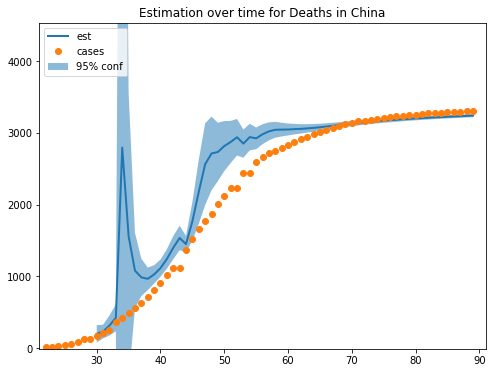

In [16]:
allPlots('China')

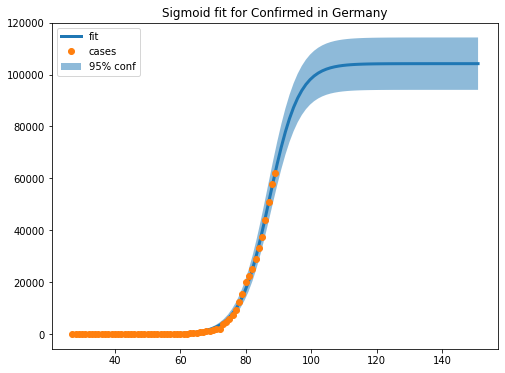

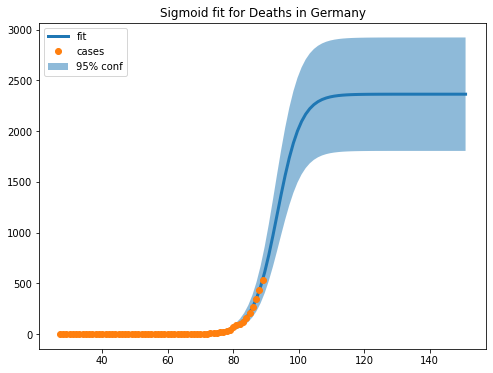

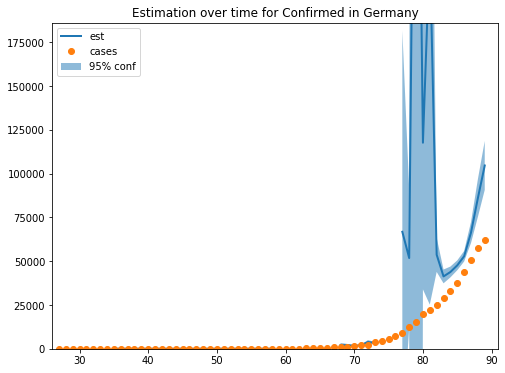

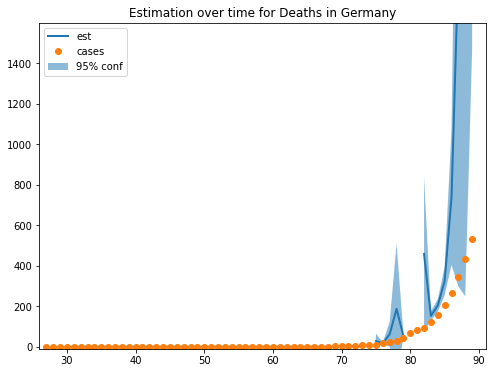

In [17]:
allPlots('Germany')

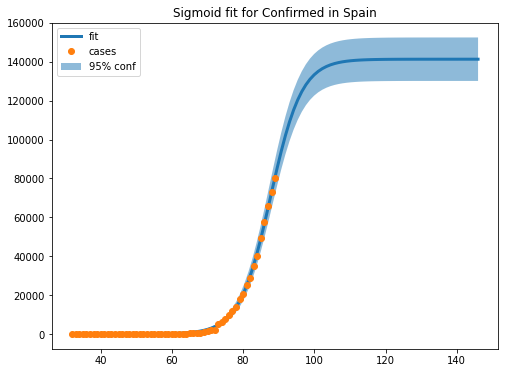

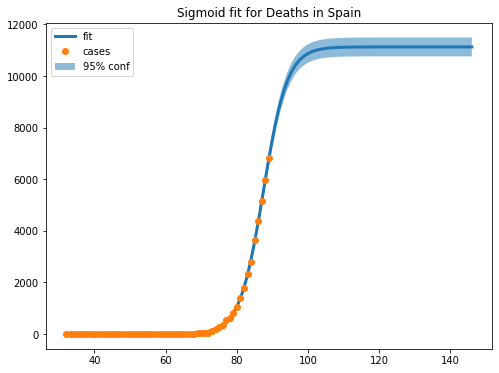

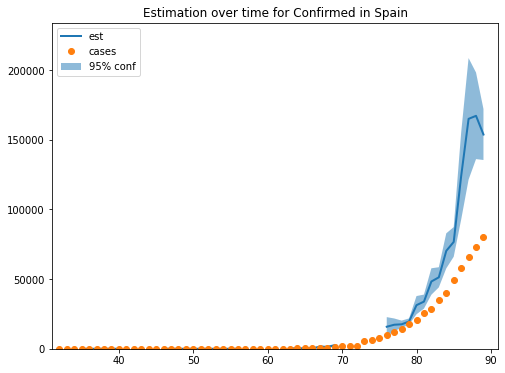

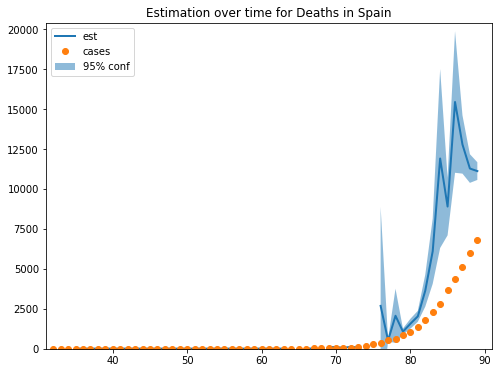

In [18]:
allPlots('Spain')

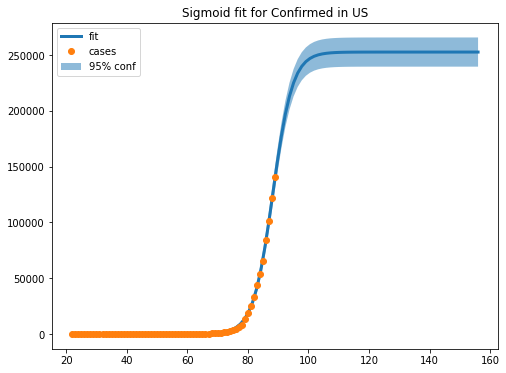

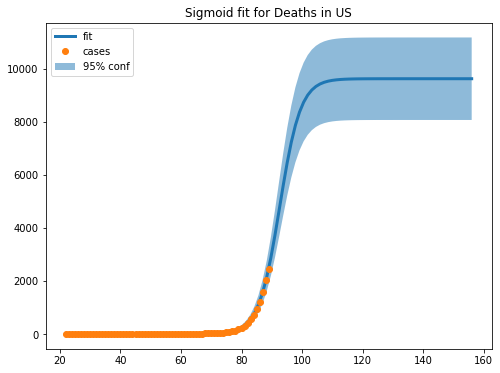

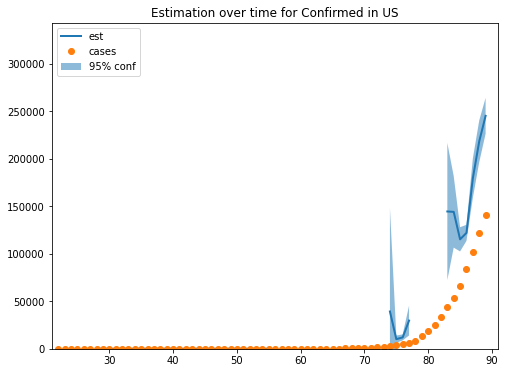

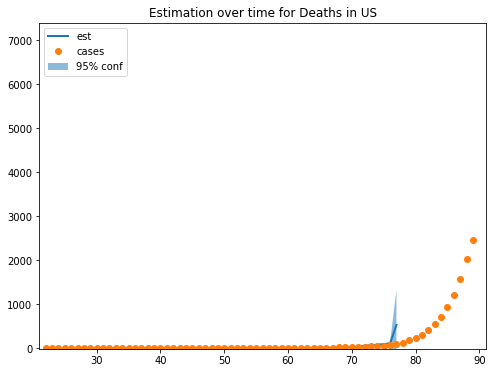

In [19]:
allPlots('US')

In [20]:
regions = ts['Country/Region'].unique()
regions

array(['China', 'Japan', 'Korea, South', 'Taiwan*', 'Thailand', 'US',
       'Vietnam', 'Singapore', 'France', 'Malaysia', 'Nepal', 'Australia',
       'Canada', 'Sri Lanka', 'Germany', 'Cambodia',
       'United Arab Emirates', 'Finland', 'Philippines', 'India',
       'Sweden', 'Russia', 'United Kingdom', 'Italy', 'Spain', 'Belgium',
       'Diamond Princess', 'Egypt', 'Iran', 'Lebanon', 'Israel', 'Oman',
       'Kuwait', 'Afghanistan', 'Bahrain', 'Iraq', 'Switzerland',
       'Algeria', 'Austria', 'Croatia', 'Pakistan', 'Norway', 'Romania',
       'North Macedonia', 'Brazil', 'Georgia', 'Greece', 'Netherlands',
       'San Marino', 'Denmark', 'Estonia', 'Nigeria', 'Lithuania',
       'Mexico', 'New Zealand', 'Belarus', 'Iceland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ireland', 'Armenia', 'Azerbaijan', 'Czechia',
       'Dominican Republic', 'Ecuador', 'Morocco', 'Latvia', 'Portugal',
       'Senegal', 'Saudi Arabia', 'Andorra', 'Indonesia', 'Ukraine',
       'Jordan', 'Chile', 'A

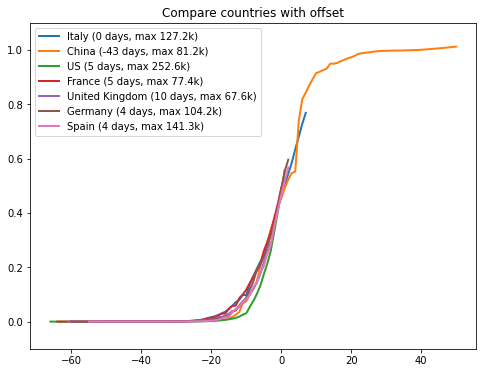

In [21]:
plotRegions(['Italy','China','US','France','United Kingdom','Germany','Spain'])

No fit for World


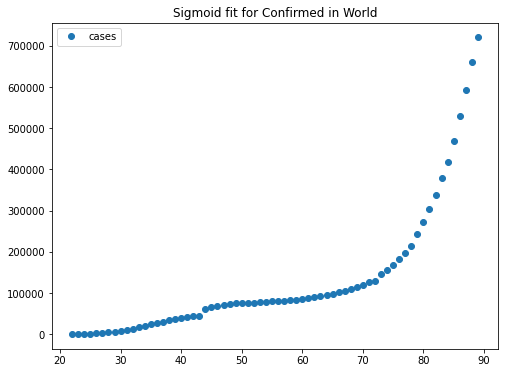

No fit for World


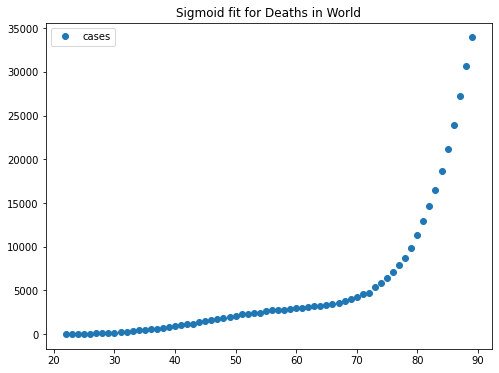

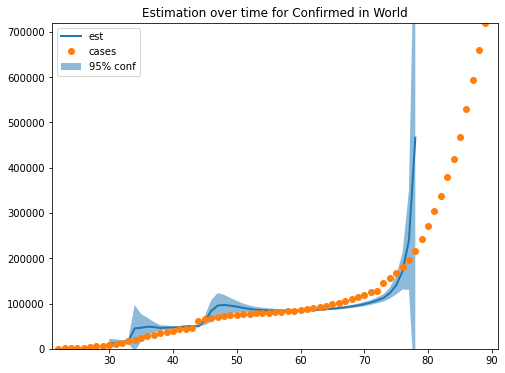

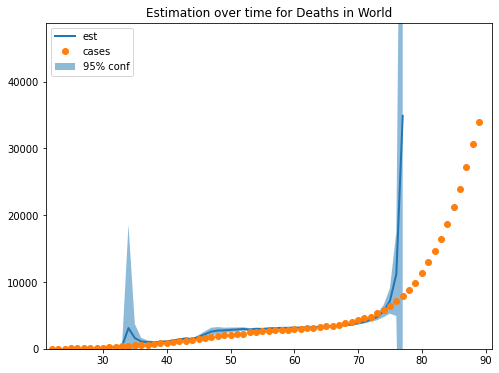

In [22]:
allPlots(None,'World')

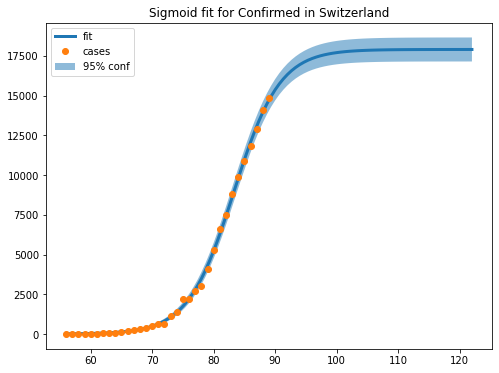

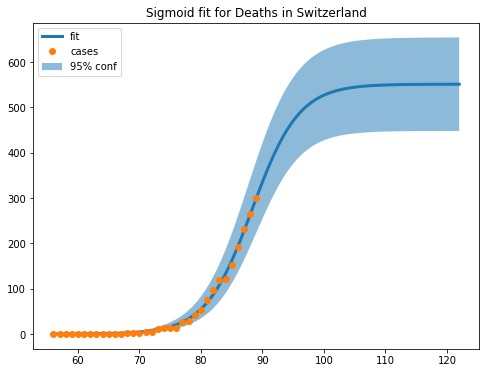

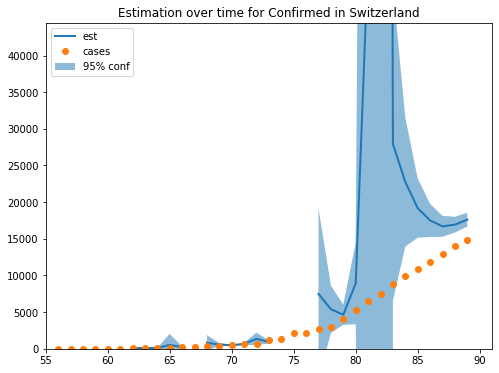

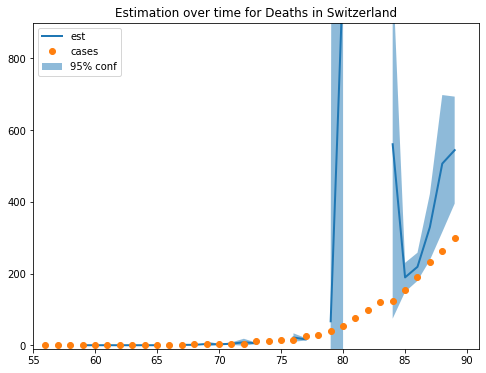

In [23]:
allPlots('Switzerland')

In [24]:
def flat(region, tolerance):
    pcov, perr = estimate(region)

    x0m = pcov[0]-perr[0]*2
    x0M = pcov[0]+perr[0]*2
    km = pcov[2]-perr[2]*2
    kM = pcov[2]+perr[2]*2
    xm = x0m - np.log(1-tolerance) / kM
    xM = x0M - np.log(1-tolerance) / km

    print("%.1f%% in %-22s: " % (tolerance*100, region), base+np.timedelta64(int(xm),'D'), base+np.timedelta64(int(xM),'D'))


In [26]:
flat('Italy',0.99)

99.0% in Italy                 :  2020-04-15 2020-04-17


In [30]:
flat('US',0.99)

99.0% in US                    :  2020-04-11 2020-04-12
